In [6]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
import plotly.express as px
import nbformat
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import plotly.figure_factory as ff
import plotly.express as px
import nbformat



In [7]:
df = pd.read_csv('song_data.csv') 
print(df.head())  # Visualiza
print(df.columns)

                    song_name  song_popularity  song_duration_ms  \
0  Boulevard of Broken Dreams               73            262333   
1                  In The End               66            216933   
2           Seven Nation Army               76            231733   
3                  By The Way               74            216933   
4           How You Remind Me               56            223826   

   acousticness  danceability  energy  instrumentalness  key  liveness  \
0      0.005520         0.496   0.682          0.000029    8    0.0589   
1      0.010300         0.542   0.853          0.000000    3    0.1080   
2      0.008170         0.737   0.463          0.447000    0    0.2550   
3      0.026400         0.451   0.970          0.003550    0    0.1020   
4      0.000954         0.447   0.766          0.000000   10    0.1130   

   loudness  audio_mode  speechiness    tempo  time_signature  audio_valence  
0    -4.095           1       0.0294  167.060               4      

In [8]:
df['is_hit'] = (df['song_popularity'] >= 60).astype(int)
print(df['is_hit'].value_counts(normalize=True)) 

is_hit
0    0.574144
1    0.425856
Name: proportion, dtype: float64


In [9]:
features = df.drop(columns=['song_name','song_popularity','is_hit'])
print(features.isnull().sum())
X = features
y = df['is_hit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
dtype: int64


In [10]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


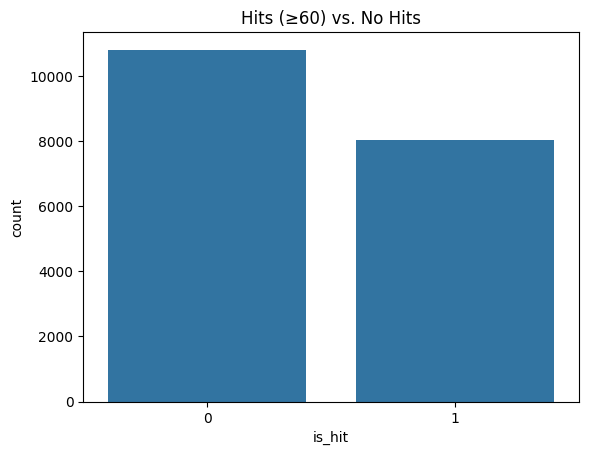

/var/folders/lg/yh68bnfn6pb_lt3_47jnjhm40000gn/T/ipykernel_39278/1445578163.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.values[:10], y=corr.index[:10], palette='coolwarm')


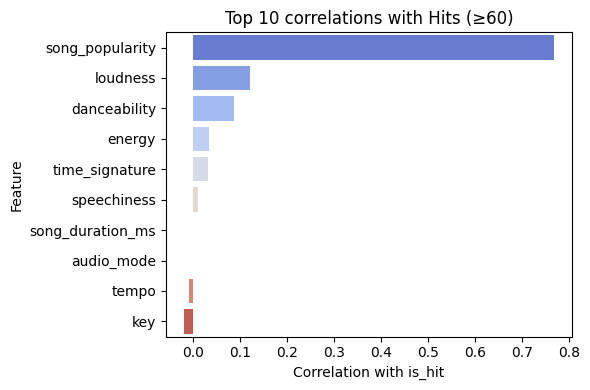

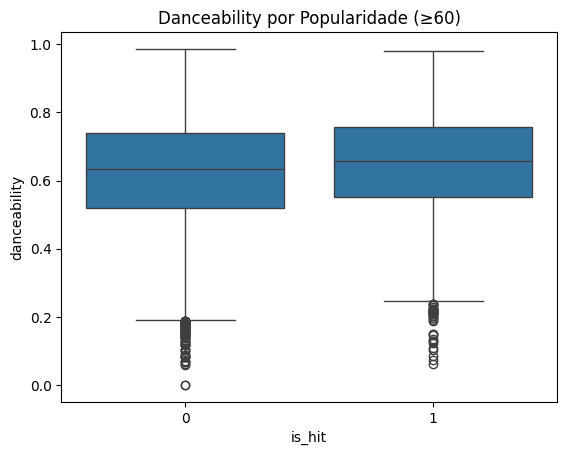

In [11]:

sns.countplot(x='is_hit', data=df)
plt.title('Hits (≥60) vs. No Hits')
plt.show()

corr = df.corr(numeric_only=True)['is_hit'].sort_values(ascending=False)

corr = corr.drop('is_hit')

plt.figure(figsize=(6, 4))
sns.barplot(x=corr.values[:10], y=corr.index[:10], palette='coolwarm')
plt.title('Top 10 correlations with Hits (≥60)')
plt.xlabel('Correlation with is_hit')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

sns.boxplot(x='is_hit', y='danceability', data=df)
plt.title('Danceability por Popularidade (≥60)')
plt.show()

In [12]:
features = X.columns.tolist()


In [13]:
selector = SelectKBest(f_classif, k=5)
selector.fit(X_train_scaled, y_train)

selected_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_indices].tolist()
print('Top features (ANOVA F-test):', selected_features)

Top features (ANOVA F-test): ['acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness']


In [14]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
print(f'Acurácia: {accuracy_score(y_test, y_pred):.2f}')

              precision    recall  f1-score   support

           0       0.76      0.89      0.82      2163
           1       0.81      0.62      0.70      1604

    accuracy                           0.77      3767
   macro avg       0.78      0.75      0.76      3767
weighted avg       0.78      0.77      0.77      3767

Acurácia: 0.77


n_estimators=100, random_state=42, class_weight='balanced'

In [15]:

cm = confusion_matrix(y_test, y_pred)
labels = ['No Hit', 'Hit']
fig = ff.create_annotated_heatmap(
    z=cm, x=labels, y=labels, colorscale='Blues', showscale=True)
fig.update_layout(title_text='Interactive Confusion Matrix')
fig.show()



importances = rf.feature_importances_
feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_df = feat_df.sort_values('Importance', ascending=False).head(10)

fig = px.bar(feat_df, 
             x='Importance', y='Feature', 
             orientation='h', 
             title='Top 10 most Important Features (Random Forest)',
             color='Importance', color_continuous_scale='Blues')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()


In [ ]:
print(f"Training accuracy: {accuracy_score(y_train, rf.predict(X_train_scaled)):.2f}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred):.2f}")
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X_scaled, y, cv=5)
print(f"Cross-val scores: {scores}, Mean: {scores.mean():.2f}")

Training accuracy: 0.99
Teste accuracy: 0.77
Cross-val scores: [0.70666313 0.78391293 0.76055216 0.78258561 0.78550571], Mean: 0.76


# Model 2: Logistic Regression (comparison)

In [17]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr.fit(X_train_scaled, y_train)
print(f"LogisticRegression Accuracy: {accuracy_score(y_test, lr.predict(X_test_scaled)):.2f}")

LogisticRegression Accuracy: 0.62


In [18]:
models = ['RandomForest', 'LogisticRegression']
scores = [accuracy_score(y_test, y_pred), accuracy_score(y_test, lr.predict(X_test_scaled))]

fig = px.bar(x=models, y=scores, title='Model Comparison',
             text=[f"{s:.2f}" for s in scores], color=models)
fig.update_layout(yaxis_title='Accuracy', xaxis_title='Model')
fig.show()


In [20]:
pred_probs = rf.predict_proba(X_test_scaled)[:, 1]
results = pd.DataFrame({
    'song_name': df.loc[X_test.index, 'song_name'],
    'pred_hit': y_pred,
    'prob_hit': pred_probs
}).sort_values('prob_hit', ascending=False)

results.to_csv('hits_predictions.csv', index=False)
